In [1]:
import sys
sys.path.append("..")

from data_utils import SCPDataSet, stratified_split
from data_utils import Sm2Smiles, Smiles2Mol, Mol2Morgan, Type2OneHot
from train import train, loss_fn
from model import *

import torch
from torch.optim import SGD, Adam
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

from sklearn.model_selection import KFold

import pandas as pd

In [2]:
de_train = pd.read_parquet("../data/de_train.parquet")

In [3]:
import os
os.chdir("..")

In [4]:
sm_smiles_df = pd.read_csv("config/sm_smiles.csv")
sm_smiles_dict = sm_smiles_df.set_index("sm_name").to_dict()["SMILES"]
ctypes = de_train['cell_type'].unique()
mtypes = de_train['sm_name'].unique()

In [19]:
cell_types = list(de_train["cell_type"])
kfold = KFold(n_splits=5, shuffle=True, random_state=65)

# train_index, val_index = stratified_split(cell_types, 0.25, 194)

mol_enc = nn.Sequential(
    nn.Linear(2048, 200)
)
cell_enc = nn.Sequential(
    nn.Linear(len(ctypes), 10)
)
regressor = nn.Sequential(
    nn.Linear(210, 100),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.Linear(100, 500),
    nn.Tanh(),
    nn.Linear(500, len(de_train.columns)-5)
)

model = CombinerModel(
        mol_encoder=mol_enc,
        cell_encoder=cell_enc,
        regressor=regressor)
torch.save(model.state_dict(), "temp/ini_model.pkl")

val_all_list, train_all_list = [], []
for fold, (train_index, val_index) in enumerate(kfold.split(de_train)):
    train_df = de_train.iloc[train_index]
    val_df = de_train.iloc[val_index]

    train_dataset = SCPDataSet(train_df)
    val_dataset = SCPDataSet(val_df)
    train_dataloader = DataLoader(train_dataset, 256)
    val_dataloader = DataLoader(val_dataset, 256)

    mol_enc_size, cell_enc_size = 20, 4

    train_all, val_all = [], []

    args = {
        "lr": 0.01,
        "epochs": 100,
        "mol_transform": [Sm2Smiles(sm_smiles_dict), Smiles2Mol(), Mol2Morgan(2048, 3)],
        "cell_transform": [Type2OneHot(ctypes)]
    }

    model.load_state_dict(torch.load("temp/ini_model.pkl"))
    optimizer = Adam(model.parameters(), lr=args["lr"], weight_decay=1e-3)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10)
    train_loss, val_loss = train(train_dataloader, val_dataloader, model, args, loss_fn, optimizer, scheduler)
    train_all += train_loss
    val_all += val_loss

    train_all_list.append(train_all)
    val_all_list.append(val_all)

 23%|██▎       | 23/100 [00:42<02:22,  1.85s/it]


KeyboardInterrupt: 

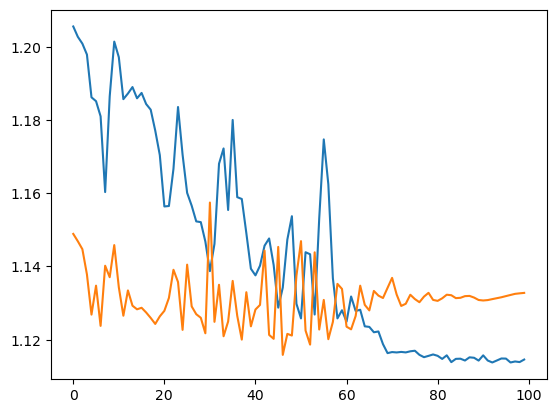

In [21]:
import matplotlib.pyplot as plt

# mins_val = [min(l) for l in val_all_list]
# mins_train = [min(l) for l in train_all_list]
# print(sum(mins_train)/len(mins_train))
# print(sum(mins_val)/len(mins_val))
plt.plot(train_all_list[1])
plt.plot(val_all_list[1])

In [39]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float)
print(x.shape)
x.mean(dim=1).shape

torch.Size([2, 3])


torch.Size([2])